In [9]:
# import dependencies for training
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torch.autograd import Variable

import tqdm

In [10]:
# load and inspect the dataset
# Read the CSV file
df = pd.read_csv('dataset1k224x224/forest_dataset.csv')

# Display the modified DataFrame
print(df)

               imageT0            imageT1  label
0      forestT0_0.jpeg    forestT1_0.jpeg      0
1      forestT0_1.jpeg    forestT1_1.jpeg      0
2      forestT0_2.jpeg    forestT1_2.jpeg      0
3      forestT0_3.jpeg    forestT1_3.jpeg      0
4      forestT0_4.jpeg    forestT1_4.jpeg      0
..                 ...                ...    ...
995  forestT0_995.jpeg  forestT1_995.jpeg      1
996  forestT0_996.jpeg  forestT1_996.jpeg      1
997  forestT0_997.jpeg  forestT1_997.jpeg      1
998  forestT0_998.jpeg  forestT1_998.jpeg      1
999  forestT0_999.jpeg  forestT1_999.jpeg      1

[1000 rows x 3 columns]


In [11]:
# Split the dataset into training and testing sets

image1_paths = df['imageT0'].tolist()
image2_paths = df['imageT1'].tolist()
print(image1_paths)
labels = df['label'].tolist()


train_image1_paths, test_image1_paths, train_image2_paths, test_image2_paths, train_labels, test_labels = train_test_split(
    image1_paths, image2_paths, labels, test_size=0.2, random_state=42
)

['forestT0_0.jpeg', 'forestT0_1.jpeg', 'forestT0_2.jpeg', 'forestT0_3.jpeg', 'forestT0_4.jpeg', 'forestT0_5.jpeg', 'forestT0_6.jpeg', 'forestT0_7.jpeg', 'forestT0_8.jpeg', 'forestT0_9.jpeg', 'forestT0_10.jpeg', 'forestT0_11.jpeg', 'forestT0_12.jpeg', 'forestT0_13.jpeg', 'forestT0_14.jpeg', 'forestT0_15.jpeg', 'forestT0_16.jpeg', 'forestT0_17.jpeg', 'forestT0_18.jpeg', 'forestT0_19.jpeg', 'forestT0_20.jpeg', 'forestT0_21.jpeg', 'forestT0_22.jpeg', 'forestT0_23.jpeg', 'forestT0_24.jpeg', 'forestT0_25.jpeg', 'forestT0_26.jpeg', 'forestT0_27.jpeg', 'forestT0_28.jpeg', 'forestT0_29.jpeg', 'forestT0_30.jpeg', 'forestT0_31.jpeg', 'forestT0_32.jpeg', 'forestT0_33.jpeg', 'forestT0_34.jpeg', 'forestT0_35.jpeg', 'forestT0_36.jpeg', 'forestT0_37.jpeg', 'forestT0_38.jpeg', 'forestT0_39.jpeg', 'forestT0_40.jpeg', 'forestT0_41.jpeg', 'forestT0_42.jpeg', 'forestT0_43.jpeg', 'forestT0_44.jpeg', 'forestT0_45.jpeg', 'forestT0_46.jpeg', 'forestT0_47.jpeg', 'forestT0_48.jpeg', 'forestT0_49.jpeg', 'forestT0

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


In [13]:
class ForestDataset(Dataset):
    def __init__(self, image1_paths, image2_paths, labels, transform=None):
        self.image1_paths = image1_paths
        self.image2_paths = image2_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #img1 = Image.open(self.image1_paths[idx]).convert('L')
        #img2 = Image.open(self.image2_paths[idx]).convert('L')
        img1 = Image.open(os.path.join(self.image1_paths[idx])).convert('L')
        img2 = Image.open(os.path.join(self.image2_paths[idx])).convert('L')
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)


        return img1, img2, label

# Define the image transformations
#transform = transforms.Compose([
#    transforms.Resize((10, 10)),
#    transforms.ToTensor(),
#])

# Transaform for SQUEEZE NET
transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1), 
                transforms.Resize((50, 50)),  # Resize to 224x224 for SqueezeNet
                transforms.ToTensor()  
            ])


folder_path = '/Users/marco/ml-verifier-oracle/training/dataset1k224x224'

# Prepend the folder path to each image path
train_image1_paths = [os.path.join(folder_path, img_path) for img_path in train_image1_paths]
train_image2_paths = [os.path.join(folder_path, img_path) for img_path in train_image2_paths]
test_image1_paths = [os.path.join(folder_path, img_path) for img_path in test_image1_paths]
test_image2_paths = [os.path.join(folder_path, img_path) for img_path in test_image2_paths]

# Create datasets and dataloaders
train_dataset = ForestDataset(train_image1_paths, train_image2_paths, train_labels, transform=transform)
test_dataset = ForestDataset(test_image1_paths, test_image2_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [14]:
# TRAIN THE MODEL
from torch.optim.lr_scheduler import StepLR
import sys
import os
import torch
import matplotlib.pyplot as plt
#from defineSNN import SiameseBambooNN
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
import numpy as np

current_dir = os.getcwd()
#project_root = os.path.abspath(os.path.join(current_dir, '..'))
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(project_root)

from training.defineSNN2 import FurtherAdjustedSiameseBambooNN, SimpleConvNet, ThirdFurtherAdjustedSiameseBambooNN, BiggerConvNet
from training.defineSNN2Squeeze import SqueezeAdjusted

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiggerConvNet().to(device)

# Display the network architecture
#print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 23365


In [15]:
criterion = torch.nn.BCEWithLogitsLoss()
#criterion = ContrastiveLoss(margin=5)


# Training loop
num_epochs = 30
learning_rates = [0.1, 0.01, 0.001]
avg_losses = {lr: [] for lr in learning_rates}
accuracies = {lr: [] for lr in learning_rates}


for lr in learning_rates:

    #optimizer =  optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    #scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(num_epochs):

        total_loss = 0
        total_batches = 0
        model.train()

        for batch in train_loader:
            img1, img2, label = batch            
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            
           
            optimizer.zero_grad()
            finalout = model(img1, img2)
            #output1 = model.forward_one(img1)
            #output2 = model.forward_one(img2)

            labels = torch.zeros_like(finalout)
            labels[label.view(-1, 1) == 1] = 1
            loss = criterion(finalout, labels.float())
            #loss = criterion(output1, output2, label.float())


            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_batches += 1

        #scheduler.step()
        average_loss = total_loss / total_batches
        avg_losses[lr].append(average_loss)
        print(f'Learning Rate: {lr}, Avg loss: {average_loss}')

    # Evaluation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for batch in test_loader:
            img1, img2, label = batch
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            finalout = model(img1, img2)
            predicted_labels = (torch.sigmoid(finalout) > 0.5).float()

            total += label.size(0)
            correct += (predicted_labels.view(-1) == label).sum().item()

        accuracy = correct / total
        accuracies[lr].append(accuracy)
        print(f'Learning Rate: {lr}, Test Accuracy: {accuracy * 100:.2f}%')


    # save just params
    torch.save(model.state_dict(), f'trained__23k__lr_{lr}B.pth')


Learning Rate: 0.1, Avg loss: 0.6871626384556293
Learning Rate: 0.1, Avg loss: 0.6768941134214401
Learning Rate: 0.1, Avg loss: 0.6702355802059173
Learning Rate: 0.1, Avg loss: 0.6674067169427872
Learning Rate: 0.1, Avg loss: 0.657243549078703
Learning Rate: 0.1, Avg loss: 0.6473672986030579
Learning Rate: 0.1, Avg loss: 0.6345814906060696
Learning Rate: 0.1, Avg loss: 0.6143718838691712
Learning Rate: 0.1, Avg loss: 0.5871528968214988
Learning Rate: 0.1, Avg loss: 0.5940261717885733
Learning Rate: 0.1, Avg loss: 0.5894525952637195
Learning Rate: 0.1, Avg loss: 0.5737143136560917
Learning Rate: 0.1, Avg loss: 0.5659689258784055
Learning Rate: 0.1, Avg loss: 0.5461084093898535
Learning Rate: 0.1, Avg loss: 0.5173649996519089
Learning Rate: 0.1, Avg loss: 0.5198461331427098
Learning Rate: 0.1, Avg loss: 0.49769509863108397
Learning Rate: 0.1, Avg loss: 0.5077002918347716
Learning Rate: 0.1, Avg loss: 0.47989513743668794
Learning Rate: 0.1, Avg loss: 0.4575543023645878
Learning Rate: 0.1,

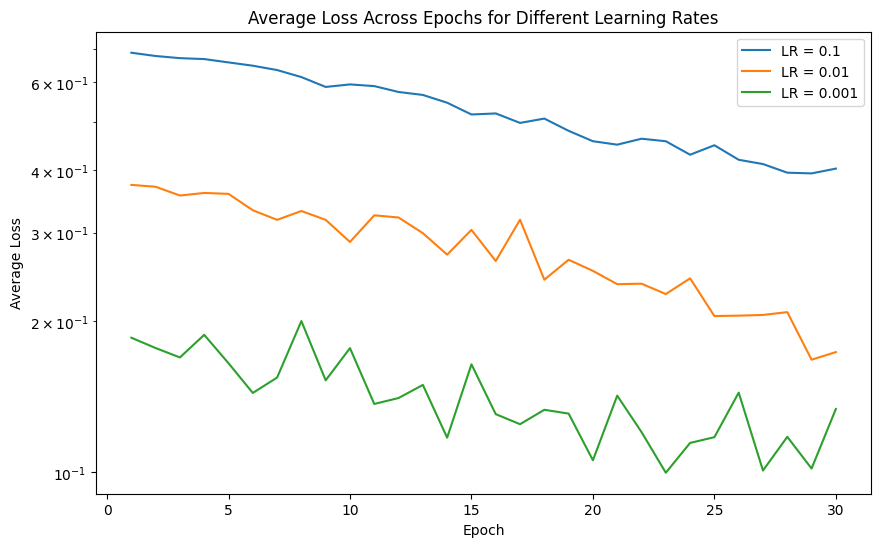

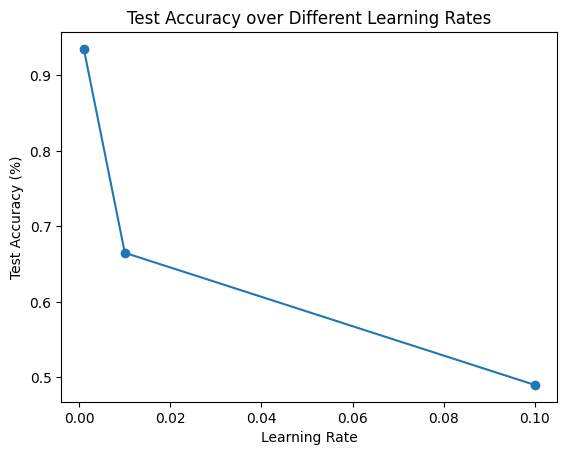

In [17]:
# Plotting the average loss for each learning rate
plt.figure(figsize=(10, 6))
for lr, losses in avg_losses.items():
    plt.plot(range(1, num_epochs + 1), losses, label=f'LR = {lr}')

plt.title('Average Loss Across Epochs for Different Learning Rates')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Average Loss')
plt.legend()
# Set axis limits
#plt.xlim(1, 8)
#plt.ylim(0, 4)
plt.show()

# Plotting accuracies over learning rates
lr_values = [lr for lr in learning_rates]
accuracy_values = [accuracies[lr][-1] for lr in learning_rates]
plt.plot(lr_values, accuracy_values, marker='o', linestyle='-')
#plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy over Different Learning Rates')
plt.show()